# Model-Based RL
In this exercise you will implement a policy and model network which work in tandem to solve the CartPole reinforcement learning problem.

What is a model and why would we want to use one? In this case, a model is going to be a neural network that attempts to learn the dynamics of the real environment. For example, in the CartPole we would like a model to be able to predict the next position of the Cart given the previous position and an action. By learning an accurate model, we can train our agent using the model rather than requiring to use the real environment every time. While this may seem less useful when the real environment is itself a simulation, like in our CartPole task, it can have huge advantages when attempting to learn policies for acting in the physical world.

How are we going to accomplish this in Tensorflow? We are going to be using a neural network that will learn the transition dynamics between a previous observation and action, and the expected new observation, reward, and done state. Our training procedure will involve switching between training our model using the real environment, and training our agent’s policy using the model environment. By using this approach we will be able to learn a policy that allows our agent to solve the CartPole task without actually ever training the policy on the real environment! 

### Loading libraries and starting CartPole environment

In [1]:
from __future__ import print_function
import numpy as np
try:
    import cPickle as pickle
except:
    import pickle
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import math

In [2]:
import sys
if sys.version_info.major > 2:
    xrange = range
del sys

In [3]:
import gym
env = gym.make('CartPole-v0')

/home/mcreng/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


### Setting Hyper-parameters

In [4]:
# hyperparameters
H = 8 # number of hidden layer neurons
learning_rate = 1e-2
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?

model_bs = 3 # Batch size when learning from model
real_bs = 3 # Batch size when learning from real environment

# model initialization
D = 4 # input dimensionality

### Policy Network

In [5]:
tf.reset_default_graph()
observations = tf.placeholder(tf.float32, [None,4] , name="input_x")
W1 = tf.get_variable("W1", shape=[4, H],
           initializer=tf.contrib.layers.xavier_initializer())
layer1 = tf.nn.relu(tf.matmul(observations,W1))
W2 = tf.get_variable("W2", shape=[H, 1],
           initializer=tf.contrib.layers.xavier_initializer())
score = tf.matmul(layer1,W2)
probability = tf.nn.sigmoid(score)

tvars = tf.trainable_variables()
input_y = tf.placeholder(tf.float32,[None,1], name="input_y")
advantages = tf.placeholder(tf.float32,name="reward_signal")
adam = tf.train.AdamOptimizer(learning_rate=learning_rate)
W1Grad = tf.placeholder(tf.float32,name="batch_grad1")
W2Grad = tf.placeholder(tf.float32,name="batch_grad2")
batchGrad = [W1Grad,W2Grad]

################################################################################
# TODO: Implement the loss function.                                           #
# This sends the weights in the direction of making actions that gave good     #
# advantage (reward overtime) more likely, and actions that didn't less likely.#
################################################################################
loglik = tf.log(input_y*(input_y - probability) + (1 - input_y)*(input_y + probability))
loss = -tf.reduce_mean(loglik * advantages) 
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

newGrads = tf.gradients(loss,tvars)
updateGrads = adam.apply_gradients(zip(batchGrad,tvars))

### Model Network
Here we implement a multi-layer neural network that predicts the next observation, reward, and done state from a current state and action.

In [6]:
mH = 256 # model layer size

input_data = tf.placeholder(tf.float32, [None, 5])
with tf.variable_scope('rnnlm'):
    softmax_w = tf.get_variable("softmax_w", [mH, 50])
    softmax_b = tf.get_variable("softmax_b", [50])

previous_state = tf.placeholder(tf.float32, [None,5] , name="previous_state")
W1M = tf.get_variable("W1M", shape=[5, mH],
           initializer=tf.contrib.layers.xavier_initializer())
B1M = tf.Variable(tf.zeros([mH]),name="B1M")
layer1M = tf.nn.relu(tf.matmul(previous_state,W1M) + B1M)
W2M = tf.get_variable("W2M", shape=[mH, mH],
           initializer=tf.contrib.layers.xavier_initializer())
B2M = tf.Variable(tf.zeros([mH]),name="B2M")
layer2M = tf.nn.relu(tf.matmul(layer1M,W2M) + B2M)
wO = tf.get_variable("wO", shape=[mH, 4],
           initializer=tf.contrib.layers.xavier_initializer())
wR = tf.get_variable("wR", shape=[mH, 1],
           initializer=tf.contrib.layers.xavier_initializer())
wD = tf.get_variable("wD", shape=[mH, 1],
           initializer=tf.contrib.layers.xavier_initializer())

bO = tf.Variable(tf.zeros([4]),name="bO")
bR = tf.Variable(tf.zeros([1]),name="bR")
bD = tf.Variable(tf.ones([1]),name="bD")


predicted_observation = tf.matmul(layer2M,wO,name="predicted_observation") + bO
predicted_reward = tf.matmul(layer2M,wR,name="predicted_reward") + bR
predicted_done = tf.sigmoid(tf.matmul(layer2M,wD,name="predicted_done") + bD)

true_observation = tf.placeholder(tf.float32,[None,4],name="true_observation")
true_reward = tf.placeholder(tf.float32,[None,1],name="true_reward")
true_done = tf.placeholder(tf.float32,[None,1],name="true_done")


predicted_state = tf.concat([predicted_observation,predicted_reward,predicted_done],1)

observation_loss = tf.square(true_observation - predicted_observation)

reward_loss = tf.square(true_reward - predicted_reward)

done_loss = tf.multiply(predicted_done, true_done) + tf.multiply(1-predicted_done, 1-true_done)
done_loss = -tf.log(done_loss)

model_loss = tf.reduce_mean(observation_loss + done_loss + reward_loss)

modelAdam = tf.train.AdamOptimizer(learning_rate=learning_rate)
updateModel = modelAdam.minimize(model_loss)

### Helper-functions

In [7]:
def resetGradBuffer(gradBuffer):
    for ix,grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
    return gradBuffer

def discount_rewards(r):
    ################################################################################
    # TODO: Implement the discounted rewards function                              #
    # Return discounted rewards weighed by gamma. Each reward will be replaced     #
    # with a weight reward that involves itself and all the other rewards occuring #
    # after it. The later the reward after it happens, the less effect it has on   #
    # the current rewards's discounted reward                                      #
    # Hint: [r0, r1, r2, ..., r_N] will look someting like:                        #
    #       [(r0 + r1*gamma^1 + ... r_N*gamma^N), (r1 + r2*gamma^1 + ...), ...]    #
    ################################################################################
    rnew = np.copy(r)
    for i in range(1, len(rnew)):
        rnew[:len(r)-i] += gamma**i * r[i:]
    return rnew        
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################

# This function uses our model to produce a new state when given a previous state and action
def stepModel(sess, xs, action):
    toFeed = np.reshape(np.hstack([xs[-1][0],np.array(action)]),[1,5])
    myPredict = sess.run([predicted_state],feed_dict={previous_state: toFeed})
    reward = myPredict[0][:,4]
    observation = myPredict[0][:,0:4]
    observation[:,0] = np.clip(observation[:,0],-2.4,2.4)
    observation[:,2] = np.clip(observation[:,2],-0.4,0.4)
    doneP = np.clip(myPredict[0][:,5],0,1)
    if doneP > 0.1 or len(xs)>= 300:
        done = True
    else:
        done = False
    return observation, reward, done

## Training the Policy and Model

In [8]:
xs,drs,ys,ds = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 1
real_episodes = 1
init = tf.global_variables_initializer()
batch_size = real_bs

drawFromModel = False # When set to True, will use model for observations
trainTheModel = True # Whether to train the model
trainThePolicy = False # Whether to train the policy
switch_point = 1

# Launch the graph
with tf.Session() as sess:
    rendering = False
    sess.run(init)
    observation = env.reset()
    x = observation
    gradBuffer = sess.run(tvars)
    gradBuffer = resetGradBuffer(gradBuffer)
    
    while episode_number <= 5000:
        # Start displaying environment once performance is acceptably high.
        if (reward_sum/batch_size > 150 and drawFromModel == False) or rendering == True : 
            env.render()
            rendering = True
            
        x = np.reshape(observation,[1,4])

        tfprob = sess.run(probability,feed_dict={observations: x})
        action = 1 if np.random.uniform() < tfprob else 0

        # record various intermediates (needed later for backprop)
        xs.append(x) 
        y = 1 if action == 0 else 0 
        ys.append(y)
        
        # step the  model or real environment and get new measurements
        if drawFromModel == False:
            observation, reward, done, info = env.step(action)
        else:
            observation, reward, done = stepModel(sess,xs,action)
                
        reward_sum += reward
        
        ds.append(done*1)
        drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

        if done: 
            
            if drawFromModel == False: 
                real_episodes += 1
            episode_number += 1

            # stack together all inputs, hidden states, action gradients, and rewards for this episode
            epx = np.vstack(xs)
            epy = np.vstack(ys)
            epr = np.vstack(drs)
            epd = np.vstack(ds)
            xs,drs,ys,ds = [],[],[],[] # reset array memory
            
            if trainTheModel == True:
                
                ################################################################################
                # TODO: Run the model network and compute predicted_state                      #
                # Output: 'pState'                                                             #
                ################################################################################
                feed_dict = {
                    previous_state: np.hstack([epx[:-1], epy[:-1]]),
                    true_observation: epx[1:],
                    true_reward: epr[1:],
                    true_done: epd[1:]
                }
                tState = np.hstack([epx[1:], epr[1:], epd[1:]])
                _, pState = sess.run([updateModel, predicted_state], feed_dict=feed_dict)
                ################################################################################
                #                                 END OF YOUR CODE                             #
                ################################################################################
                

            if trainThePolicy == True:
                
                ################################################################################
                # TODO: Run the policy network and compute newGrads                            #
                # Output: 'tGrad'                                                              #
                ################################################################################
                # compute the discounted reward backwards through time
                discounted_epr = discount_rewards(epr)
                # size the rewards to be unit normal (helps control the gradient estimator variance)
                discounted_epr -= np.mean(discounted_epr)
                discounted_epr //= np.std(discounted_epr)
                tGrad = sess.run(newGrads, feed_dict={observations: epx, input_y: epy, advantages: discounted_epr})
                ################################################################################
                #                                 END OF YOUR CODE                             #
                ################################################################################
                
                # If gradients becom too large, end training process
                if np.sum(tGrad[0] == tGrad[0]) == 0:
                    break
                for ix,grad in enumerate(tGrad):
                    gradBuffer[ix] += grad
                
            if switch_point + batch_size == episode_number: 
                switch_point = episode_number
                if trainThePolicy == True:
                    
                    ################################################################################
                    # TODO:                                                                        #
                    # (1) Run the policy network and update gradients                              #
                    # (2) Reset gradBuffer to 0                                                    #
                    ################################################################################
                    sess.run(updateGrads, feed_dict={W1Grad: gradBuffer[0], W2Grad: gradBuffer[1]})
                    for idx, _ in enumerate(tGrad):
                        gradBuffer[idx] = 0                    
                    ################################################################################
                    #                                 END OF YOUR CODE                             #
                    ################################################################################

                running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
                if drawFromModel == False:
                    print('World Perf: Episode %f. Reward %f. action: %f. mean reward %f.' % (real_episodes,reward_sum/real_bs,action, running_reward/real_bs))
                    if reward_sum/batch_size > 200:
                        break
                reward_sum = 0

                # Once the model has been trained on 100 episodes
                if episode_number > 100:
                    
                    ################################################################################
                    # TODO: Alternating between training the policy from the model and training    #
                    # the model from the real environment.                                         #
                    ################################################################################
                    drawFromModel = not drawFromModel
                    trainTheModel = not trainTheModel
                    trainThePolicy = not trainThePolicy
                    ################################################################################
                    #                                 END OF YOUR CODE                             #
                    ################################################################################
            
            if drawFromModel == True:
                observation = np.random.uniform(-0.1,0.1,[4]) # Generate reasonable starting point
                batch_size = model_bs
            else:
                observation = env.reset()
                batch_size = real_bs
                
print(real_episodes)

World Perf: Episode 4.000000. Reward 15.666667. action: 1.000000. mean reward 15.666667.
World Perf: Episode 7.000000. Reward 20.666667. action: 0.000000. mean reward 15.716667.
World Perf: Episode 10.000000. Reward 13.000000. action: 0.000000. mean reward 15.689500.
World Perf: Episode 13.000000. Reward 33.333333. action: 1.000000. mean reward 15.865938.
World Perf: Episode 16.000000. Reward 29.666667. action: 0.000000. mean reward 16.003946.
World Perf: Episode 19.000000. Reward 17.333333. action: 1.000000. mean reward 16.017239.
World Perf: Episode 22.000000. Reward 19.333333. action: 1.000000. mean reward 16.050400.
World Perf: Episode 25.000000. Reward 16.333333. action: 0.000000. mean reward 16.053230.
World Perf: Episode 28.000000. Reward 35.333333. action: 1.000000. mean reward 16.246031.
World Perf: Episode 31.000000. Reward 17.666667. action: 1.000000. mean reward 16.260237.
World Perf: Episode 34.000000. Reward 29.666667. action: 1.000000. mean reward 16.394301.
World Perf: 

World Perf: Episode 277.000000. Reward 17.000000. action: 0.000000. mean reward 22.269899.
World Perf: Episode 280.000000. Reward 20.000000. action: 1.000000. mean reward 22.566629.
World Perf: Episode 283.000000. Reward 13.333333. action: 0.000000. mean reward 23.030386.
World Perf: Episode 286.000000. Reward 11.666667. action: 1.000000. mean reward 22.787188.
World Perf: Episode 289.000000. Reward 18.000000. action: 1.000000. mean reward 22.669678.
World Perf: Episode 292.000000. Reward 20.333333. action: 1.000000. mean reward 22.705328.
World Perf: Episode 295.000000. Reward 13.333333. action: 1.000000. mean reward 22.489738.
World Perf: Episode 298.000000. Reward 17.666667. action: 0.000000. mean reward 22.564270.
World Perf: Episode 301.000000. Reward 11.666667. action: 1.000000. mean reward 22.285477.
World Perf: Episode 304.000000. Reward 13.333333. action: 1.000000. mean reward 22.083900.
World Perf: Episode 307.000000. Reward 14.000000. action: 1.000000. mean reward 22.041801.

World Perf: Episode 550.000000. Reward 15.000000. action: 1.000000. mean reward 60.779758.
World Perf: Episode 553.000000. Reward 12.333333. action: 1.000000. mean reward 62.020569.
World Perf: Episode 556.000000. Reward 15.000000. action: 0.000000. mean reward 64.100906.
World Perf: Episode 559.000000. Reward 17.666667. action: 1.000000. mean reward 66.076271.
World Perf: Episode 562.000000. Reward 12.000000. action: 1.000000. mean reward 65.583565.
World Perf: Episode 565.000000. Reward 11.666667. action: 1.000000. mean reward 66.728165.
World Perf: Episode 568.000000. Reward 10.333333. action: 1.000000. mean reward 66.337807.
World Perf: Episode 571.000000. Reward 14.000000. action: 0.000000. mean reward 65.294777.
World Perf: Episode 574.000000. Reward 11.333333. action: 1.000000. mean reward 66.364372.
World Perf: Episode 577.000000. Reward 11.333333. action: 1.000000. mean reward 68.223724.
World Perf: Episode 580.000000. Reward 17.000000. action: 0.000000. mean reward 70.001762.

World Perf: Episode 823.000000. Reward 12.666667. action: 1.000000. mean reward 81.766670.
World Perf: Episode 826.000000. Reward 12.000000. action: 0.000000. mean reward 80.523346.
World Perf: Episode 829.000000. Reward 16.000000. action: 1.000000. mean reward 79.876427.
World Perf: Episode 832.000000. Reward 12.666667. action: 0.000000. mean reward 78.609543.
World Perf: Episode 835.000000. Reward 10.000000. action: 1.000000. mean reward 77.628052.
World Perf: Episode 838.000000. Reward 13.000000. action: 1.000000. mean reward 79.163155.
World Perf: Episode 841.000000. Reward 16.000000. action: 0.000000. mean reward 80.743401.
World Perf: Episode 844.000000. Reward 12.333333. action: 1.000000. mean reward 79.348190.
World Perf: Episode 847.000000. Reward 10.000000. action: 0.000000. mean reward 78.381699.
World Perf: Episode 850.000000. Reward 20.000000. action: 0.000000. mean reward 77.345428.
World Perf: Episode 853.000000. Reward 13.333333. action: 1.000000. mean reward 77.614372.

World Perf: Episode 1093.000000. Reward 10.666667. action: 0.000000. mean reward 77.557396.
World Perf: Episode 1096.000000. Reward 13.666667. action: 1.000000. mean reward 79.188423.
World Perf: Episode 1099.000000. Reward 16.333333. action: 0.000000. mean reward 80.793648.
World Perf: Episode 1102.000000. Reward 9.666667. action: 1.000000. mean reward 82.226990.
World Perf: Episode 1105.000000. Reward 10.666667. action: 1.000000. mean reward 81.075615.
World Perf: Episode 1108.000000. Reward 17.000000. action: 1.000000. mean reward 79.697235.
World Perf: Episode 1111.000000. Reward 11.666667. action: 1.000000. mean reward 81.286919.
World Perf: Episode 1114.000000. Reward 12.000000. action: 1.000000. mean reward 82.720848.
World Perf: Episode 1117.000000. Reward 9.666667. action: 1.000000. mean reward 81.313751.
World Perf: Episode 1120.000000. Reward 12.666667. action: 0.000000. mean reward 79.959946.
World Perf: Episode 1123.000000. Reward 11.333333. action: 0.000000. mean reward 8

World Perf: Episode 1360.000000. Reward 10.000000. action: 1.000000. mean reward 109.810646.
World Perf: Episode 1363.000000. Reward 13.333333. action: 1.000000. mean reward 110.559448.
World Perf: Episode 1366.000000. Reward 10.333333. action: 1.000000. mean reward 111.469185.
World Perf: Episode 1369.000000. Reward 14.000000. action: 0.000000. mean reward 112.386345.
World Perf: Episode 1372.000000. Reward 10.333333. action: 0.000000. mean reward 113.205986.
World Perf: Episode 1375.000000. Reward 11.666667. action: 0.000000. mean reward 114.025612.
World Perf: Episode 1378.000000. Reward 9.666667. action: 0.000000. mean reward 114.807518.
World Perf: Episode 1381.000000. Reward 9.000000. action: 1.000000. mean reward 113.972412.
World Perf: Episode 1384.000000. Reward 10.666667. action: 1.000000. mean reward 114.712196.
World Perf: Episode 1387.000000. Reward 11.000000. action: 1.000000. mean reward 112.751625.
World Perf: Episode 1390.000000. Reward 10.000000. action: 0.000000. mea

World Perf: Episode 1627.000000. Reward 8.666667. action: 1.000000. mean reward 117.882996.
World Perf: Episode 1630.000000. Reward 9.333333. action: 0.000000. mean reward 118.587532.
World Perf: Episode 1633.000000. Reward 9.000000. action: 1.000000. mean reward 119.293701.
World Perf: Episode 1636.000000. Reward 9.666667. action: 0.000000. mean reward 117.216766.
World Perf: Episode 1639.000000. Reward 10.666667. action: 0.000000. mean reward 117.351288.
World Perf: Episode 1642.000000. Reward 11.333333. action: 1.000000. mean reward 115.366432.
World Perf: Episode 1645.000000. Reward 9.333333. action: 0.000000. mean reward 116.196320.
World Perf: Episode 1648.000000. Reward 9.666667. action: 1.000000. mean reward 116.639961.
World Perf: Episode 1651.000000. Reward 11.666667. action: 0.000000. mean reward 117.394020.
World Perf: Episode 1654.000000. Reward 11.000000. action: 1.000000. mean reward 118.209259.
World Perf: Episode 1657.000000. Reward 11.000000. action: 0.000000. mean re

World Perf: Episode 1894.000000. Reward 9.666667. action: 1.000000. mean reward 145.112717.
World Perf: Episode 1897.000000. Reward 9.666667. action: 1.000000. mean reward 145.250870.
World Perf: Episode 1900.000000. Reward 9.666667. action: 0.000000. mean reward 145.537659.
World Perf: Episode 1903.000000. Reward 11.000000. action: 0.000000. mean reward 145.802551.
World Perf: Episode 1906.000000. Reward 10.666667. action: 1.000000. mean reward 145.958847.
World Perf: Episode 1909.000000. Reward 9.333333. action: 1.000000. mean reward 146.095993.
World Perf: Episode 1912.000000. Reward 9.333333. action: 0.000000. mean reward 143.555191.
World Perf: Episode 1915.000000. Reward 11.000000. action: 1.000000. mean reward 143.744888.
World Perf: Episode 1918.000000. Reward 9.666667. action: 0.000000. mean reward 143.929932.
World Perf: Episode 1921.000000. Reward 9.333333. action: 0.000000. mean reward 144.236710.
World Perf: Episode 1924.000000. Reward 10.000000. action: 0.000000. mean rew

World Perf: Episode 2161.000000. Reward 9.333333. action: 0.000000. mean reward 145.566879.
World Perf: Episode 2164.000000. Reward 12.333333. action: 0.000000. mean reward 145.773270.
World Perf: Episode 2167.000000. Reward 11.000000. action: 1.000000. mean reward 145.993240.
World Perf: Episode 2170.000000. Reward 8.666667. action: 0.000000. mean reward 146.179916.
World Perf: Episode 2173.000000. Reward 9.666667. action: 1.000000. mean reward 146.362823.
World Perf: Episode 2176.000000. Reward 9.000000. action: 1.000000. mean reward 146.523956.
World Perf: Episode 2179.000000. Reward 11.333333. action: 1.000000. mean reward 146.665863.
World Perf: Episode 2182.000000. Reward 10.333333. action: 0.000000. mean reward 146.817719.
World Perf: Episode 2185.000000. Reward 10.333333. action: 1.000000. mean reward 146.971100.
World Perf: Episode 2188.000000. Reward 9.333333. action: 1.000000. mean reward 147.135483.
World Perf: Episode 2191.000000. Reward 9.000000. action: 0.000000. mean re

World Perf: Episode 2428.000000. Reward 9.666667. action: 0.000000. mean reward 141.664062.
World Perf: Episode 2431.000000. Reward 10.333333. action: 0.000000. mean reward 141.832535.
World Perf: Episode 2434.000000. Reward 8.333333. action: 1.000000. mean reward 142.042404.
World Perf: Episode 2437.000000. Reward 10.333333. action: 0.000000. mean reward 142.419434.
World Perf: Episode 2440.000000. Reward 11.333333. action: 0.000000. mean reward 142.620041.
World Perf: Episode 2443.000000. Reward 9.333333. action: 1.000000. mean reward 142.864136.
World Perf: Episode 2446.000000. Reward 9.666667. action: 1.000000. mean reward 143.142517.
World Perf: Episode 2449.000000. Reward 9.333333. action: 0.000000. mean reward 143.338928.
World Perf: Episode 2452.000000. Reward 13.000000. action: 1.000000. mean reward 143.579727.
World Perf: Episode 2455.000000. Reward 10.666667. action: 0.000000. mean reward 143.807907.
World Perf: Episode 2458.000000. Reward 9.000000. action: 1.000000. mean re

### Checking model representation
Here we can examine how well the model is able to approximate the true environment after training. The green line indicates the real environment, and the blue indicates model predictions.

/home/mcreng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


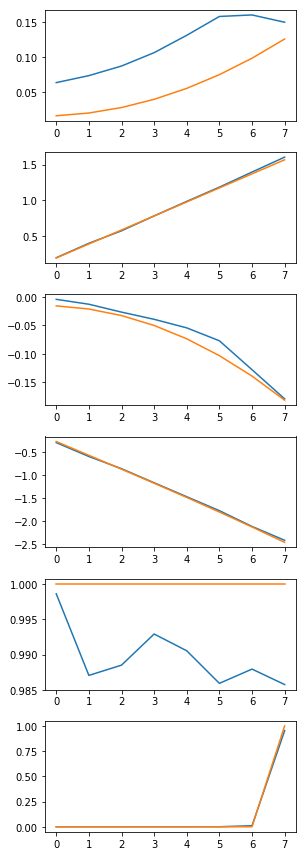

In [9]:
plt.figure(figsize=(8, 12))
for i in range(6):
    plt.subplot(6, 2, 2*i + 1)
    plt.plot(pState[:,i])   # draw the model predictions
    plt.subplot(6,2,2*i+1)
    
    ################################################################################
    # TODO: draw the real environment for comparison                               #
    ################################################################################
    plt.plot(tState[:,i])
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################
plt.tight_layout()